# Feature Engineering & Selection

Objective: perform exhaustive feature selection 
- Perform statistical tests on features. Examine distributions and variance within the feature, and distance between features
- Examine different scaling approaches (standardizing, centering, log transformations, etc.)
- Use spark_sklearn or spark directly for computationally challenging iterations
- Use the best model pipeline found in the campaign_targeting_model_BATCH notebook

In [1]:
import pickle
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#pickle.load(open('finalized_model.sav', 'rb'))
#Current feature importances for the GBM model:
#pipe_gbm.named_steps['clf'].feature_importances_

In [3]:
df = pd.read_pickle('data/data_ready.pickle')

In [4]:
df.drop(columns=['duration', 'day'], axis=1, inplace=True)

In [5]:
df.y = [1 if i == 'yes' else 0 for i in df.y]

In [6]:
df_outliers = df.select_dtypes(include=['int64', 'float64'])

In [7]:
df_outliers.columns

Index(['year', 'month', 'age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'weekday', 'month_total_days', 'is_holiday', 'biz_payday',
       'govt_payday'],
      dtype='object')

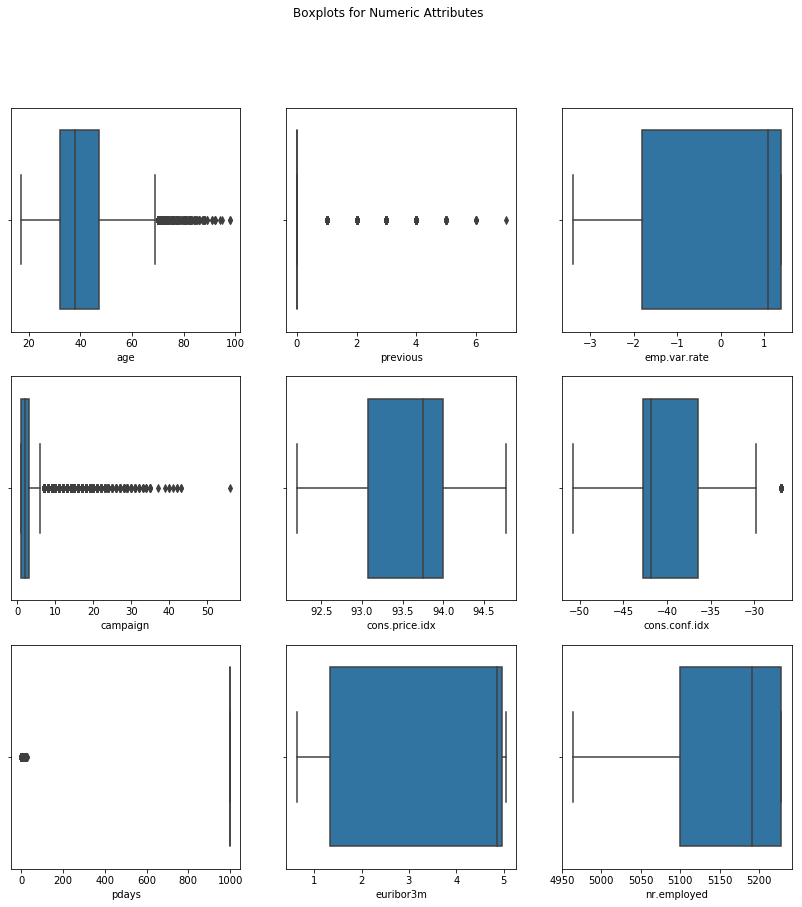

In [8]:
fig, axes = plt.subplots(3,3, figsize=(14,14))

sns.boxplot(x=df_outliers['age'], ax=axes[0,0])
sns.boxplot(x=df_outliers['campaign'], ax=axes[1,0])
sns.boxplot(x=df_outliers['pdays'], ax=axes[2,0])
sns.boxplot(x=df_outliers['previous'], ax=axes[0,1])
sns.boxplot(x=df_outliers['emp.var.rate'], ax=axes[0,2])
sns.boxplot(x=df_outliers['cons.price.idx'], ax=axes[1,1])
sns.boxplot(x=df_outliers['cons.conf.idx'], ax=axes[1,2])
sns.boxplot(x=df_outliers['euribor3m'], ax=axes[2,1])
sns.boxplot(x=df_outliers['nr.employed'], ax=axes[2,2])

plt.suptitle('Boxplots for Numeric Attributes')

plt.show()

The pdays attributes inlcudes values of 999 indicating the lead was never contacted in a prior campaign. As shown above, the wide majority of instances have this value (see feat_eng_tests notebook for more details). Let's analyze further this subset of the data.

In [9]:
df[df['pdays'] != 999].shape

(1515, 28)

In [10]:
df_old = df[df['pdays'] != 999]

In [11]:
print('Percentage of subscriptions for customers that had been contacted in a previous campaign: ')
print('{:.2f}%'.format(df_old.y.sum()*100/len(df_old)))

Percentage of subscriptions for customers that had been contacted in a previous campaign: 
63.83%


In [12]:
del df_old

Aside from the obvious business reasons, because the subscription rate is so high we will not eliminate the instances where pdays is not 999. We will however create a flag, binary feature for customers that are not new.

Let's look at the "previous" attribute to see if a similar pattern is present. The 'previous' attribute represents number of contacts performed before this campaign and for this client (numeric).

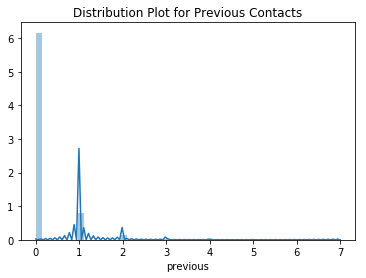

In [13]:
sns.distplot(df_outliers.previous)
plt.title('Distribution Plot for Previous Contacts')
plt.show()

As shown above, the wide majority of customers have no previous contacts as indeed they were contacted for the first time as part of the current campaign. Of the remaining instances, the majority was contacted only once. There is no need to create a new binary attribute as it would be identical to the binary attribute related to pdays that we will build. 

Given the above distribution, the previous attribute is probably not going to be very useful but we will keep it unchanged as there is no benefit in removing outliers. 

Next, we will examine the campaign attribute which represents the number of contacts performed during this campaign and for this client (numeric, includes last contact)

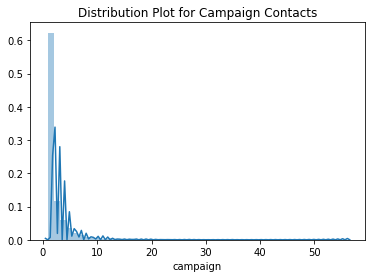

In [14]:
sns.distplot(df_outliers.campaign)
plt.title('Distribution Plot for Campaign Contacts')
plt.show()

It appears as if the majority of the instances during the campaign are first time contacts. It looks like there are a few values that are very far from the center of the distribution. Also, we might take into consideration an exponential transformation. 

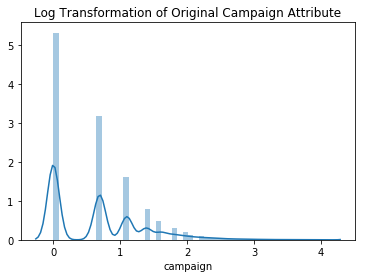

In [15]:
sns.distplot(np.log(df_outliers['campaign']))
plt.title("Log Transformation of Original Campaign Attribute")
plt.show()

Because of the heavy skew we cannot just consider outliers to be instances outside the IQR range (times 1.5) as done with normal distributions. Furthermore, there might be reasons why some of the instances show such high values for this attribute. Let's investigate more this subset of the data.

In [17]:
#Investigating instances above the 0.75 quantile threshold:
df_temp = df_outliers[df_outliers['campaign'] > 3]

In [18]:
df_temp.shape

(7635, 17)

In [19]:
print('Percentage of subscriptions for customers above the campaign threshold: ')
print('{:.2f}%'.format(df_temp.y.sum()*100/len(df_temp)))

Percentage of subscriptions for customers above the campaign threshold: 
7.27%


In [44]:
df_plot1 = df_temp[['campaign', 'y']].groupby(['campaign']).count().reset_index()
df_plot2 = df_temp[['campaign', 'y']].groupby(['campaign']).sum().reset_index()

In [50]:
df_plot1.rename(columns={'y':'count'}, inplace=True)
df_plot2.rename(columns={'y':'sum_y'}, inplace=True)

In [53]:
df_plot = df_plot1.merge(df_plot2, how='inner', on='campaign')

In [94]:
df_plot['count'] = pd.to_numeric(df_plot['count'], errors='coerce')
df_plot['campaign'] = pd.to_numeric(df_plot['campaign'])
df_plot['sum_y'] = pd.to_numeric(df_plot['sum_y'])

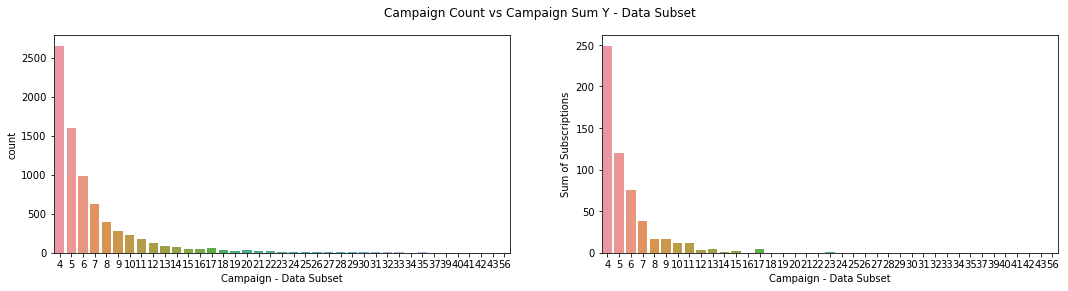

In [105]:
fig, axes = plt.subplots(1,2, figsize=(18,4))
sns.countplot(x=df_temp.campaign, ax=axes[0])
sns.barplot(x=df_plot.campaign, y=df_plot.sum_y, ax=axes[1])
axes[1].set(xlabel = "Campaign - Data Subset", ylabel='Sum of Subscriptions')
axes[0].set(xlabel = "Campaign - Data Subset")
plt.suptitle('Campaign Count vs Campaign Sum Y - Data Subset')
plt.show()

In this subset of the data, there doesn't seem to be any benefit in repeated contacts with potential customers. In fact, we have very few subscriptions beyond the seventh contact. Repeated attempts might have a detrimental effect in terms of brand image so the business should probably set a cap for the number of attempts at selling the subscription offer.

In [107]:
def plot_boxplots(df):
    fig, axes = plt.subplots(3,3, figsize=(14,14))

    sns.boxplot(x=df['age'], ax=axes[0,0])
    sns.boxplot(x=df['campaign'], ax=axes[1,0])
    sns.boxplot(x=df['pdays'], ax=axes[2,0])
    sns.boxplot(x=df['previous'], ax=axes[0,1])
    sns.boxplot(x=df['emp.var.rate'], ax=axes[0,2])
    sns.boxplot(x=df['cons.price.idx'], ax=axes[1,1])
    sns.boxplot(x=df['cons.conf.idx'], ax=axes[1,2])
    sns.boxplot(x=df['euribor3m'], ax=axes[2,1])
    sns.boxplot(x=df['nr.employed'], ax=axes[2,2])

    plt.suptitle('Boxplots for Numeric Attributes')

    plt.show()

Let's plot the nine numeric features with respect to this subset of the data to evaluate how much variance is present in it

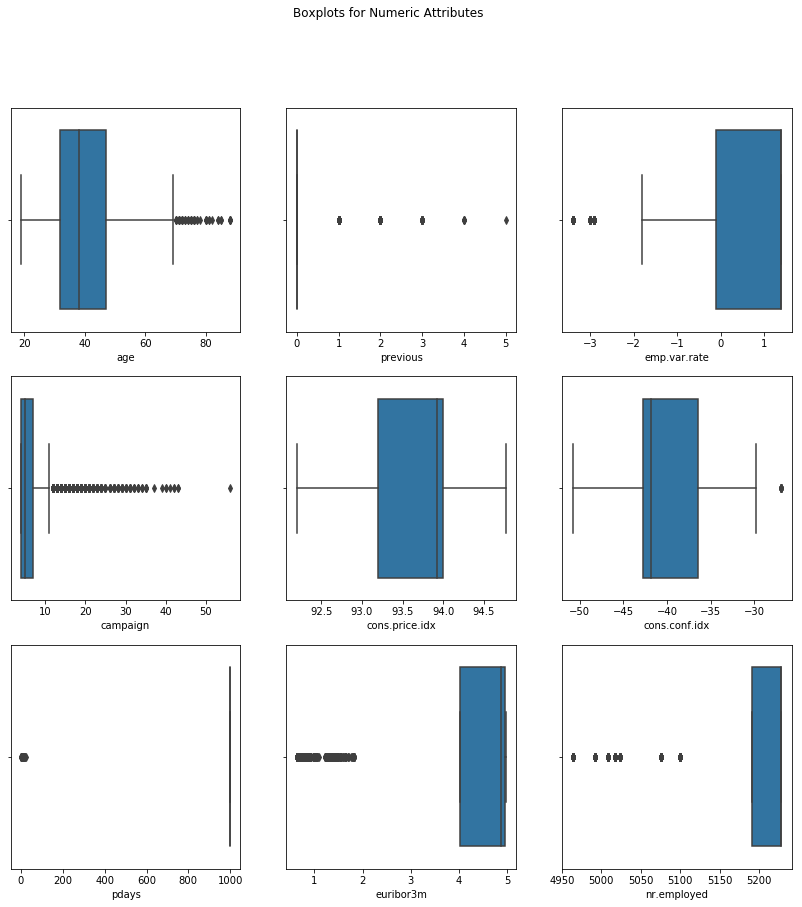

In [108]:
plot_boxplots(df_temp)

Let us also visualize this subset of the data with respect to categorical attributes:

Categorical Features:

marital                      
education                    
default                      
housing                      
loan                         
contact                      
month_last_contact           
day_of_week_last_contact
poutcome

In [132]:
def plot_cat_countplots(df):
    fig, axes = plt.subplots(3,3, figsize=(14,14))

    sns.barplot(x="marital", y="y", data=df_temp_cat, estimator=sum, ax=axes[0,0])
    g =  sns.barplot(x="education", y="y", data=df_temp_cat, estimator=sum, ax=axes[1,0])
    sns.barplot(x="default", y="y", data=df_temp_cat, estimator=sum, ax=axes[2,0])
    sns.barplot(x="housing", y="y", data=df_temp_cat, estimator=sum, ax=axes[0,1])
    sns.barplot(x="loan", y="y", data=df_temp_cat, estimator=sum, ax=axes[0,2])
    sns.barplot(x="contact", y="y", data=df_temp_cat, estimator=sum, ax=axes[1,1])
    sns.barplot(x="month_last_contact", y="y", data=df_temp_cat, estimator=sum, ax=axes[1,2])
    sns.barplot(x="day_of_week_last_contact", y="y", data=df_temp_cat, estimator=sum, ax=axes[2,1])
    sns.barplot(x="poutcome", y="y", data=df_temp_cat, estimator=sum, ax=axes[2,2])
    
    g.set_xticklabels(axes[1,0].get_xticklabels(), rotation=40)
    
    plt.suptitle('Sum of Y for Categorical Attributes')

    plt.show()

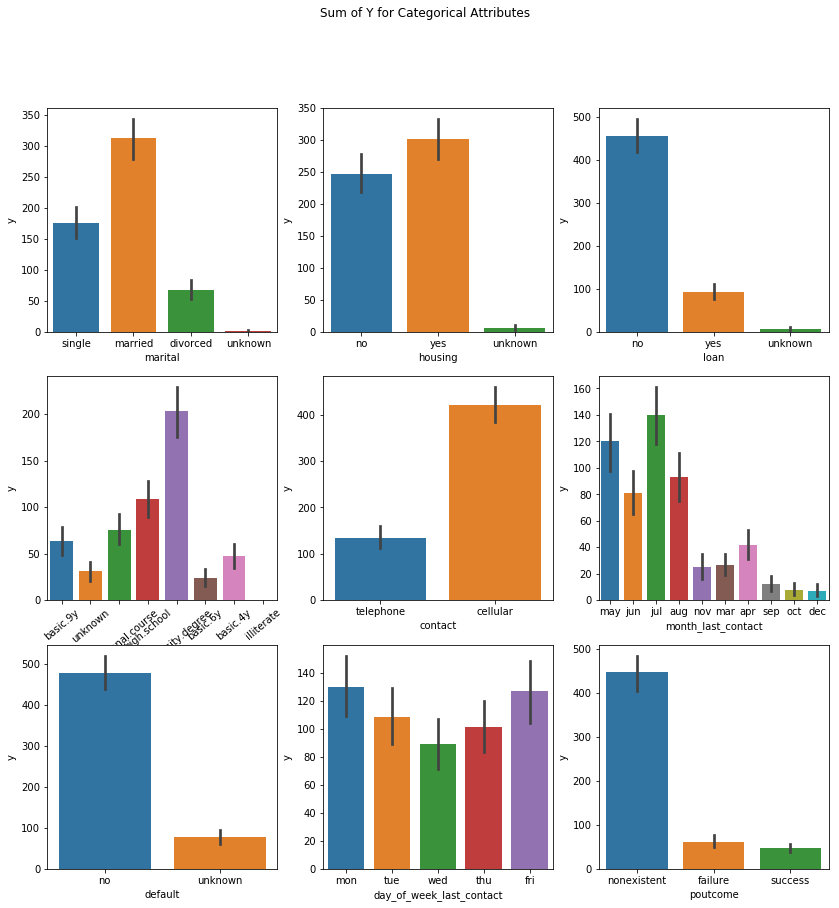

In [133]:
plot_cat_countplots(df[df['campaign'] > 3])

From a modeling perspective, this subset of the data contains a decent amount of variance. As a result, we will only applya logarithmic transformation without dropping the outliers. In general, it would have been ok to drop this subset of the data if it didn't carry much information, but we have a high class imbalance so we have no reason to drop these instances.

In [ ]:
df_temp

In [ ]:
#DO OUTLIER ANALYSIS HERE

Creating Features

In [5]:
#Step 1: we start by binning some of the numeric features. 
#For a visualization of these please visit notebook "feat_eng_tests" located in the same folder.

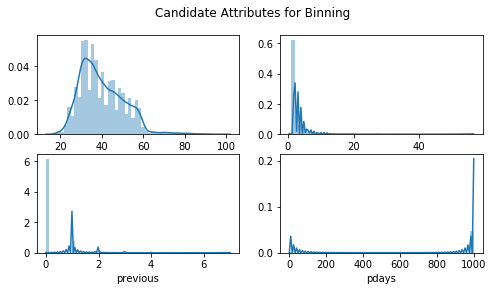

In [16]:
fig, axes = plt.subplots(2,2,figsize=(8,4))

sns.distplot(df.age, ax=axes[0,0])
sns.distplot(df.previous, ax=axes[1,0])
sns.distplot(df.campaign, ax=axes[0,1])
sns.distplot(df.pdays, ax=axes[1,1])

plt.suptitle('Candidate Attributes for Binning')
plt.show()

The only clear candidate for binning is age. Perhaps we could bin campaign as well. No need to bin pdays and previous. If anything, a flag attribute for pdays = 999 could be created

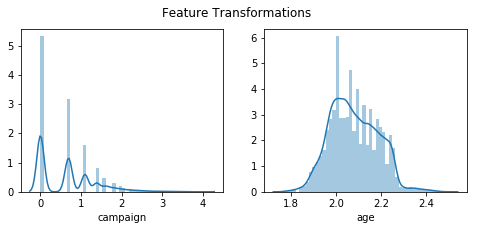

In [40]:
fig, axes = plt.subplots(1,2,figsize=(8,3))

sns.distplot(np.log(df.campaign), ax=axes[0])
sns.distplot((df.age**(1/5)), ax=axes[1])

plt.suptitle("Feature Transformations")
plt.show()

We might consider a log transformation for campaign and/or an exponential transformation for age

In [41]:
#Creating some new categorical features with binning:
df['age_bin'] = pd.cut(df['age'], 4, labels = [0,1,2,3])
df['campaign_bin'] = pd.cut(df['campaign'], 4, labels = [0,1,2,3])

In [42]:
#One hot encoding the new features:
df = pd.get_dummies(df, columns = ['age_bin', 'campaign_bin', 'contact'], drop_first=True)

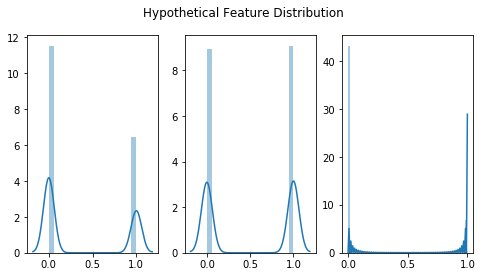

In [46]:
fig, axes = plt.subplots(1,3,figsize=(8,4))

sns.distplot(np.where((df.previous ==0)&(df.campaign==1),1,0), ax=axes[0])
sns.distplot(np.where((df.previous ==0)&(df.campaign>1),1,0), ax=axes[1])
sns.distplot(np.where((df.previous > 0),1,0), ax=axes[2])

plt.suptitle('Hypothetical Feature Distribution')
plt.show()

Creating some flags for new leads vs prspects and repeat customers soudns like a good idea, but based on the above visualization it seems that there is little variance in the seccond case so we will only create features reflecting graphs 1 and 3

In [47]:
#Creating some flags reflecting whther if the customer is a new lead, 
#was previously contacted as part of the same campaign, or an old prospect 
#i.e. someone who was contacted in a previous campaign (for a visualization please visit "feat_eng_tests"

df['new_lead'] = np.where((df.previous ==0)&(df.campaign==1),1,0)
#Simple check
#len(df[df['new_lead']==1])

#df['new_prospect'] = np.where((df.previous ==0)&(df.campaign>1),1,0)
#Simple check
#len(df[df['new_prospect']==1])

df['old_prospect'] = np.where((df.previous > 0),1,0)
#Simple check
#len(df[df['old_prospect']==1])

In [48]:
#It looks like two of the new one hot encoded features contain only zeros. We remove them
set(df.columns) - set(list(df.loc[:, (df != 0).any(axis=0)]))

set()

In [49]:
df.drop(columns=list(set(df.columns) - set(list(df.loc[:, (df != 0).any(axis=0)]))), inplace=True)

Step 2: understand what currently are the features most correlated with y

In [196]:
%store -r numeric_features

In [198]:
#preparing dataframe for correlation analysis
df_corr = df.copy()
df_corr.reset_index(inplace=True)
df_corr.drop('Date', axis=1, inplace=True)
df_corr.drop(columns=numeric_features, inplace=True)
df_corr['y'] = [1 if i == 'yes' else 0 for i in df_corr['y']]

In [199]:
def check_all(pdseries):
    if all(x == pdseries[0] for x in pdseries):
        print("All elements in list are equal")
        print('Feature name: ', pdseries.name)
    else:
        pass

In [200]:
#Checking for any features that have the same value - this would cause an error when calculating correlations.
df_corr.apply(lambda x: check_all(x))

All elements in list are equal
Feature name:  year
All elements in list are equal
Feature name:  month
All elements in list are equal
Feature name:  job
All elements in list are equal
Feature name:  marital
All elements in list are equal
Feature name:  education
All elements in list are equal
Feature name:  default
All elements in list are equal
Feature name:  housing
All elements in list are equal
Feature name:  loan
All elements in list are equal
Feature name:  month_last_contact
All elements in list are equal
Feature name:  day_of_week_last_contact
All elements in list are equal
Feature name:  poutcome
All elements in list are equal
Feature name:  y
All elements in list are equal
Feature name:  weekday
All elements in list are equal
Feature name:  is_holiday
All elements in list are equal
Feature name:  holiday_name
All elements in list are equal
Feature name:  biz_payday
All elements in list are equal
Feature name:  govt_payday
All elements in list are equal
Feature name:  new_lead

year                        None
month                       None
job                         None
marital                     None
education                   None
default                     None
housing                     None
loan                        None
month_last_contact          None
day_of_week_last_contact    None
poutcome                    None
y                           None
weekday                     None
is_holiday                  None
holiday_name                None
biz_payday                  None
govt_payday                 None
new_lead                    None
new_prospect                None
old_prospect                None
age_bin_1                   None
age_bin_2                   None
age_bin_3                   None
previous_bin_1              None
previous_bin_2              None
previous_bin_3              None
campaign_bin_1              None
campaign_bin_2              None
campaign_bin_3              None
pdays_bin_3                 None
contact_te

In [210]:
df_corr[(df_corr['previous_bin_3']>0)]

,year,month,job,marital,education,default,housing,loan,month_last_contact,day_of_week_last_contact,...,age_bin_2,age_bin_3,previous_bin_1,previous_bin_2,previous_bin_3,campaign_bin_1,campaign_bin_2,campaign_bin_3,pdays_bin_3,contact_telephone
40395,2010,8,admin.,divorced,university.degree,no,no,no,aug,thu,...,0,0,0,0,1,0,0,0,0,0
40421,2010,8,management,married,unknown,no,yes,no,aug,fri,...,1,0,0,0,1,0,0,0,0,0
40436,2010,8,management,married,university.degree,no,yes,no,aug,mon,...,0,0,0,0,1,0,0,0,1,0
41081,2010,11,admin.,divorced,high.school,no,yes,no,nov,tue,...,0,0,0,0,1,0,0,0,0,0
41090,2010,11,admin.,single,university.degree,no,no,yes,nov,wed,...,0,0,0,0,1,0,0,0,0,0
41174,2010,11,retired,married,university.degree,no,yes,no,nov,thu,...,1,0,0,0,1,0,0,0,0,0


In [ ]:
from scipy import stats
import math
#Correlation between features and (binary) target var
pbcorr_list = []
for i in df_corr.columns:
    if math.isnan(stats.pointbiserialr(df_corr[i],df_corr['y'])[0]) != True:
        pbcorr_list.append((str(i), stats.pointbiserialr(df_corr[i],df_corr['y'])[0]))

In [ ]:
#Keeping features exhibiting stronger correlation with target var: 
list(filter(lambda x: x[1] < -.1, pbcorr_list)) + list(filter(lambda x: x[1] > .10, pbcorr_list)) 

INSERT CHI SQUARE TEST HERE

Based on the above, we pick some attributes so we can create new feature combinations. The list above could be filtered out with higher or lower correlation threshold and this exercise could be repeated in multiple iterations. A new feature will be created for each tuple in combos.

In [1]:
cols = ['pdays_bin_3', 'previous_bin_1', 'old_prospect', 
        'poutcome_success', 'month_last_contact_mar', 
        'contact_telephone', 'month_5', 'year_2010', 
        'poutcome_nonexistent']

In [2]:
import itertools
combos = []
for r in range(4,len(cols)):
    combos+= [i for i in list(itertools.combinations(cols, r))]

In [ ]:
def create_cat_features(df, combos, pred_var, operation):
    
    if operation == 'sum':
    
        for combo in combos:
            df_temp = df[list(combo) + [pred_var]].groupby(list(combo)).sum().reset_index(drop=0)
            combo_name = pred_var +'-'+'-'.join(combo)+'-categorical'
            df_temp.rename(columns = {pred_var:combo_name}, inplace=True)
            df = df.merge(df_temp, how='left', on=list(combo))
    
    elif operation == 'avg':
        
        for combo in combos:
            df_temp = df[list(combo) + [pred_var]].groupby(list(combo)).mean().reset_index(drop=0)
            combo_name = pred_var +'-'+'-'.join(combo)+'-categorical'
            df_temp.rename(columns = {pred_var:combo_name}, inplace=True)
            df = df.merge(df_temp, how='left', on=list(combo))
    
    else:
        print("You have entered the wrong operation")
        print("Please enter sum or avg")
    
    return df

In [ ]:
new_df_pdays = create_cat_features(df, combos, 'pdays', 'avg')

In [ ]:
new_df_camp = create_cat_features(df, combos, 'campaign', 'avg')

In [ ]:
new_df_prev = create_cat_features(df, combos, 'previous', 'avg')

In [ ]:
MORE FEATURES WITH MORE COMBOS HERE

In [ ]:
new_df_pdays = new_df_pdays.merge(new_df_camp, left_index=True, right_index=True,how='inner', suffixes=('', '_rightdf'))
new_df_pdays = new_df_pdays.merge(new_df_prev, left_index=True, right_index=True,how='inner', suffixes=('', '_rightdf'))

In [ ]:
final_df = new_df_pdays.drop(new_df_pdays.filter(regex="_rightdf").columns, axis=1)

In [ ]:
#Checking outputs:
final_df['previous-old_prospect-poutcome_success-month_last_contact_mar-contact_telephone-month_5-year_2010-categorical'].unique()
final_df['previous-pdays_bin_3-old_prospect-poutcome_success-month_last_contact_mar-contact_telephone-month_5-year_2010-categorical'].unique()

In [ ]:
SELECT K BEST HERE

Next we will modify our pipeline to include a feature selection step and see if the new features help us increase accuracy

In [ ]:
#Not needed since we will directly get dummies with the four new attributes
#categorical_features.extend(['age_bin', 'previous_bin', 'campaign_bin', 'pdays_bin'])

In [ ]:
numeric_features.extend(list(filter(lambda x: x.endswith('categorical'), final_df.columns)))



In [ ]:
binary_features.extend(['new_lead', 'old_prospect'])

In [ ]:
Next we create a new pipeline to process the dataset with RFECV

In [ ]:
def new_pipeline(numeric_features, bin_features, lab_bin_features, 
                 model, X_train, X_test, y_train, y_test):

    #numeric_features and categorical_features must be lists

    numeric_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])

    binary_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('binary', Binarizer())])
    
    #label_binary_transformer = Pipeline(steps=[
        #('imputer', SimpleImputer(strategy='most_frequent')),
        #('label_binary', OneHotEncoder(sparse=False))])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('bin', binary_transformer, bin_features) 
        #('lab_bin', label_binary_transformer, lab_bin_features) 
    ], 
        #setting remainder to passthrough so features that are not included are not dropped
        remainder='passthrough')
    
    selector = RFECV(estimator = model, step = 40, cv=StratifiedKFold(n_splits=2, random_state=1))

    combined_features = FeatureUnion([('preprocessor', preprocessor),
                                    ('selection', selector)])
    
    X_train_new = combined_features.fit(X_train,y_train).transform(X_train)
    
    pipeline = Pipeline([('features', combined_features), ("model", model)])
    
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    
    
    #cv_metric = cross_val_score(gs, X_train, y_train, cv=cv)

    print("\n---------")
    print("Model Evaluated: ", model)
    print("Test Score: %.3f" % score)

    return X_train_new, combined_features

In [ ]:
X_train, X_test, y_train, y_test = split_data(final_df, 'y', 0.2)

In [ ]:
best_gb_fs = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=1,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [ ]:
X_train_new, combined_features = new_pipeline(numeric_features, binary_features, _, 
                 best_gb_fs, X_train, X_test, y_train, y_test)

In [64]:
import findspark
findspark.init('/Users/pauldefusco/Documents/spark-2.3.0-bin-hadoop2.7')

In [65]:
from pyspark import SparkContext
sc = SparkContext(master="local[4]")
sc

<SparkContext master=local[4] appName=pyspark-shell>

In [66]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import GradientBoostingClassifier
#from spark_sklearn import GridSearchCV

In [67]:
from pyspark.sql import SQLContext
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [68]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StandardScaler, Binarizer, VectorAssembler
from pyspark.ml.linalg import Vectors

In [78]:
%store -r numeric_features
%store -r categorical_features
%store -r binary_features
%store -r label_binary

In [69]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv', names=['Date', 'y'])
y_test = pd.read_csv('data/y_test.csv', names=['Date', 'y'])

In [70]:
#spark ml models do not take separate inputs for X and y. So concatenating y_train back to X_train and y_test to X_test:
X_train = X_train.merge(y_train, how='inner', left_index=True, right_index=True)
X_test = X_test.merge(y_test, how='inner', left_index=True, right_index=True)
X_train.drop(columns=['Date_x', 'Date_y'], inplace=True)
X_test.drop(columns=['Date_x', 'Date_y'], inplace=True)

In [71]:
#Encoding the contact feature directly because there is no label encoder in pyspark
#ideally, I would prefer to keep as much encoding as possible in the Pipeline
X_train['contact'] = [1 if i == 'cellular' else 0 for i in X_train.contact]
X_test['contact'] = [1 if i == 'cellular' else 0 for i in X_test.contact]
X_train['y'] = [1 if i == 'yes' else 0 for i in X_train.y]
X_test['y'] = [1 if i == 'yes' else 0 for i in X_test.y]

In [72]:
#need to rename features with a dot as dots are not allowed in feature names in pyspark:
X_train.rename(columns = {'emp.var.rate':'emp_var_rate', 'cons.price.idx':'cons_price_idx', 
                          'cons.conf.idx': 'cons_cond_idx', 'nr.employed':'nr_employed'}, inplace=True)
#need to rename features with a dot as dots are not allowed in feature names in pyspark:
X_test.rename(columns = {'emp.var.rate':'emp_var_rate', 'cons.price.idx':'cons_price_idx', 
                          'cons.conf.idx': 'cons_cond_idx', 'nr.employed':'nr_employed'}, inplace=True)

In [118]:
X_train.columns = list(map(lambda x: x.replace('.', '_'), X_train.columns))
X_test.columns = list(map(lambda x: x.replace('.', '_'), X_train.columns))

In [119]:
X_train.columns

Index(['age', 'contact', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_cond_idx', 'euribor3m', 'nr_employed',
       'month_total_days', 'is_holiday', 'biz_payday', 'govt_payday',
       'poutcome_nonexistent', 'poutcome_success', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic_6y', 'education_basic_9y',
       'education_high_school', 'education_illiterate',
       'education_professional_course', 'education_university_degree',
       'education_unknown', 'default_unknown', 'default_yes',
       'housing_unknown', 'housing_yes', 'loan_unknown', 'loan_yes',
       'month_last_contact_aug', 'month_last_contact_dec',
       'month_last_contact_jul', 'month_last_contact_jun',
       'month_last_contact_mar', 'month

In [120]:
categorical_features.extend(['is_holiday', 'biz_payday', 'govt_payday', 
                            'poutcome_nonexistent', 'poutcome_success', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic_6y', 'education_basic_9y',
       'education_high_school', 'education_illiterate',
       'education_professional_course', 'education_university_degree',
       'education_unknown', 'default_unknown', 'default_yes',
       'housing_unknown', 'housing_yes', 'loan_unknown', 'loan_yes',
       'month_last_contact_aug', 'month_last_contact_dec',
       'month_last_contact_jul', 'month_last_contact_jun',
       'month_last_contact_mar', 'month_last_contact_may',
       'month_last_contact_nov', 'month_last_contact_oct',
       'month_last_contact_sep', 'day_of_week_last_contact_mon',
       'day_of_week_last_contact_thu', 'day_of_week_last_contact_tue',
       'day_of_week_last_contact_wed', 'holiday_name_Implantação da República',
       'holiday_name_No Holiday', 'holiday_name_Restauração da Independência',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'year_2009',
       'year_2010', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12'])

In [122]:
numeric_features = list(map(lambda word: word.replace('emp.var.rate', 'emp_var_rate')
         .replace('cons.price.idx', 'cons_price_idx')
         .replace('cons.conf.idx', 'cons_cond_idx')
         .replace('nr.employed', 'nr_employed')
         , numeric_features))

In [123]:
features = categorical_features + binary_features + label_binary

In [145]:
final = [i for i in features if i in X_train.columns]  

In [146]:
sqlContext = SQLContext(sc)

In [147]:
X_train_spark = sqlContext.createDataFrame(X_train)
X_test_spark = sqlContext.createDataFrame(X_test)

In [148]:
X_train_spark.head(2)

[Row(age=30, contact=1, campaign=1, pdays=999, previous=0, emp_var_rate=-1.8, cons_price_idx=92.893, cons_cond_idx=-46.2, euribor3m=1.2990000000000002, nr_employed=5099.1, month_total_days=31, is_holiday=0, biz_payday=0, govt_payday=0, poutcome_nonexistent=1, poutcome_success=0, job_blue-collar=1, job_entrepreneur=0, job_housemaid=0, job_management=0, job_retired=0, job_self-employed=0, job_services=0, job_student=0, job_technician=0, job_unemployed=0, job_unknown=0, marital_married=1, marital_single=0, marital_unknown=0, education_basic_6y=1, education_basic_9y=0, education_high_school=0, education_illiterate=0, education_professional_course=0, education_university_degree=0, education_unknown=0, default_unknown=1, default_yes=0, housing_unknown=0, housing_yes=1, loan_unknown=0, loan_yes=0, month_last_contact_aug=0, month_last_contact_dec=0, month_last_contact_jul=0, month_last_contact_jun=0, month_last_contact_mar=0, month_last_contact_may=1, month_last_contact_nov=0, month_last_conta

In [149]:
#X_train_spark.printSchema()

In [150]:
#X_train_spark.registerTempTable("X_train")
#X_test_spark.registerTempTable("X_test")
#X_train_spark.registerTempTable("y_train")
#X_test_spark.registerTempTable("y_test")

Recreating preprocessing pipeline

In [170]:
stages = []

In [152]:
numeric_assembler = VectorAssembler(
        inputCols=numeric_features,
        outputCol="num_features")

In [153]:
numeric_scaler = StandardScaler(inputCol="num_features", outputCol="scaledFeatures",
                        withStd=True, withMean=True)

In [154]:
final.append('scaledFeatures')

In [167]:
assembler = VectorAssembler(inputCols = final, outputCol = "feature_set")

In [168]:
#Referencing model chosen in campaign_targeting_model_BATCH:
"""
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=1,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
              """

"\nGradientBoostingClassifier(criterion='friedman_mse', init=None,\n              learning_rate=0.5, loss='deviance', max_depth=3,\n              max_features=None, max_leaf_nodes=None,\n              min_impurity_decrease=0.0, min_impurity_split=None,\n              min_samples_leaf=1, min_samples_split=2,\n              min_weight_fraction_leaf=0.0, n_estimators=100,\n              n_iter_no_change=None, presort='auto', random_state=1,\n              subsample=1.0, tol=0.0001, validation_fraction=0.1,\n              verbose=0, warm_start=False)\n              "

In [169]:
gbt = GBTClassifier(labelCol = 'y', featuresCol = 'feature_set', maxIter=5, maxDepth=3, seed=42, 
                    lossType='logistic', stepSize=0.5)

In [171]:
stages.extend([numeric_assembler, numeric_scaler, assembler, gbt])

In [172]:
pipeline = Pipeline(stages=stages)

In [175]:
model = pipeline.fit(X_train_spark)

In [176]:
predictions = model.transform(X_train_spark)

In [178]:
cols=['age', 'contact', 'campaign', 'pdays','prediction']
predictions.select(cols).show()

+---+-------+--------+-----+----------+
|age|contact|campaign|pdays|prediction|
+---+-------+--------+-----+----------+
| 30|      1|       1|  999|       0.0|
| 58|      0|       4|  999|       0.0|
| 32|      1|       1|  999|       0.0|
| 26|      0|       1|  999|       0.0|
| 48|      1|       1|  999|       0.0|
| 26|      0|       3|  999|       0.0|
| 33|      1|       1|  999|       0.0|
| 33|      1|       2|  999|       0.0|
| 32|      0|       1|  999|       0.0|
| 40|      0|       5|  999|       0.0|
| 59|      1|       3|  999|       0.0|
| 28|      1|       1|  999|       0.0|
| 50|      1|       1|  999|       0.0|
| 24|      1|       6|  999|       0.0|
| 43|      0|       1|  999|       0.0|
| 24|      1|       1|  999|       0.0|
| 50|      1|       1|  999|       0.0|
| 47|      1|       2|    6|       1.0|
| 45|      1|       1|  999|       0.0|
| 37|      0|       3|  999|       0.0|
+---+-------+--------+-----+----------+
only showing top 20 rows



In [ ]:
ADD SPARK FEATURE SELECTION STEPS TO SPARK PIPELINE ABOVE

In [ ]:
DO SPARK PCA HERE TO CAPTURE DATA STRUCTURE

In [ ]:
DO NEW ROUND OF HYPERPARAMETER TUNING FOR GBTClassifier WITH 

In [2]:
#sc.stop()